In [63]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from gensim.models import Word2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun)
display(user_choices_cmun)

[48067,
 33038,
 39045,
 33001,
 33061,
 39066,
 39088,
 48030,
 39034,
 39101,
 20027,
 39098,
 39021,
 39026,
 48092,
 39014,
 31024,
 48058,
 39004,
 48065,
 20006,
 48094,
 20010,
 20041,
 48025,
 20023,
 31087,
 20021,
 39013,
 31129,
 31263,
 39010,
 39071,
 27039,
 33068,
 20044,
 31102,
 31031,
 9215,
 39070,
 15080,
 9189,
 27011,
 31055,
 20034,
 15010,
 31236,
 9025,
 9908,
 24130,
 24145,
 39027,
 31115,
 33022,
 9903,
 31112,
 31127,
 31904,
 31133,
 31003,
 9409,
 34160,
 31240,
 39092,
 31091,
 31073,
 24114,
 31118,
 1021,
 24012,
 25063,
 25045,
 34199,
 24110,
 27037,
 31210,
 31193,
 15007,
 36059,
 31019,
 9102,
 24167,
 31154,
 31253,
 9361,
 36020,
 15042,
 1902,
 9328,
 1037,
 9109,
 24019,
 9054,
 24184,
 31121,
 27060,
 9905,
 24102,
 31011,
 9244,
 15018,
 34107,
 9306,
 1014,
 31124,
 31168,
 31206,
 9283,
 9272,
 34005,
 22068,
 9016,
 9057,
 31001,
 31116,
 24007,
 34037,
 24092,
 31204,
 31162,
 22059,
 27008,
 9001,
 25123,
 22253,
 24057,
 31225,
 24011,

[44050, 9038, 13046, 2022, 3134]

In [64]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)

,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score
0,3.175921,2.722825,0.138070,-0.889260,0.692736,1.319032
1,-0.594445,-0.382365,-0.719419,-0.889260,-0.301287,-0.755973
2,-0.098095,-0.382365,-0.540520,-0.889260,-1.295311,1.319032
3,-0.439604,-0.382365,-0.579225,-0.889260,-3.283357,-0.755973
4,-0.558315,-0.382365,0.802916,-0.126296,0.692736,-0.237222


,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score
0,0.621053,0.492637,1.268902,1.018151,0.692736,-0.237222
1,1.472676,0.972821,0.738659,1.781115,0.692736,-0.237222
2,-0.364765,-0.382365,-0.546772,-0.126296,0.692736,-0.237222
3,0.608150,0.524650,-0.132860,1.018151,0.692736,-1.015349
4,-0.419819,-0.382365,-0.328056,-0.889260,0.692736,-1.015349
...,...,...,...,...,...,...
1318,-0.540251,-0.382365,0.781699,1.018151,0.692736,1.319032
1319,-0.509282,-0.382365,0.833747,0.255186,0.692736,0.800281
1320,-0.309710,-0.382365,0.833747,0.255186,0.692736,0.800281
1321,-0.307990,-0.382365,1.260218,0.255186,0.692736,1.059656


In [48]:
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features  # drop non numeric columns
similarity_matrix = cosine_similarity(feature_matrix)

# Add edges based on similarity threshold
threshold = 0.75  # Adjust threshold based on data distribution
for i in range(len(feature_matrix)):
    for j in range(i + 1, len(feature_matrix)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [ ]:
# from sklearn.metrics import silhouette_score
# import numpy as np

# # Test different dimensions
# dimensions_to_test = [16, 24, 32, 48, 64]
# scores = []

# for dim in dimensions_to_test:
#     # Create and train model
#     node2vec = Node2Vec(G, dimensions=dim, walk_length=10, num_walks=20, workers=12)
#     model = node2vec.fit(window=5, min_count=1)
    
#     # Extract embeddings
#     embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    
#     # Evaluate using silhouette score (requires clustering)
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=5, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
#     score = silhouette_score(embeddings, clusters)
    
#     scores.append((dim, score))
#     print(f"Dimensions: {dim}, Silhouette Score: {score:.4f}")

# # Find best dimension
# best_dim = max(scores, key=lambda x: x[1])[0]
# print(f"Best dimension: {best_dim}")

In [55]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=24, walk_length=15, num_walks=30, workers=12)


Generating walks (CPU: 12): 100%|██████████| 2/2 [00:00<00:00, 13.10it/s]


In [56]:
model = node2vec.fit(
    window=10,        # Increased from 5
    min_count=1,      # Keep as is
    batch_words=100,  # Increased from 4
    epochs=15,        # Added parameter
    sg=1,             # Added parameter (Skip-gram)
    hs=0,             # Added parameter (Negative sampling)
    negative=7        # Added parameter
)

In [57]:
display(similarity_matrix)

array([[ 1.        ,  0.67683308,  0.25220336, ...,  0.12888797,
         0.23854645,  0.49709292],
       [ 0.67683308,  1.        ,  0.04421231, ..., -0.0635256 ,
        -0.01530673,  0.59966503],
       [ 0.25220336,  0.04421231,  1.        , ..., -0.25340306,
        -0.20163297, -0.2551804 ],
       ...,
       [ 0.12888797, -0.0635256 , -0.25340306, ...,  1.        ,
         0.90183469, -0.05101175],
       [ 0.23854645, -0.01530673, -0.20163297, ...,  0.90183469,
         1.        ,  0.00946051],
       [ 0.49709292,  0.59966503, -0.2551804 , ..., -0.05101175,
         0.00946051,  1.        ]])

In [58]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec_embeddings.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec_embeddings.model
Graph saved to ../../models/village_graph.pkl


In [59]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")


NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 1031: Similarity 0.9969
Village 1149: Similarity 0.9478
Village 566: Similarity 0.9465
Village 524: Similarity 0.9365
Village 284: Similarity 0.9293
Village 132: Similarity 0.9255
Village 505: Similarity 0.9236
Village 1105: Similarity 0.9226
Village 1165: Similarity 0.9211
Village 988: Similarity 0.9159


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_92613/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


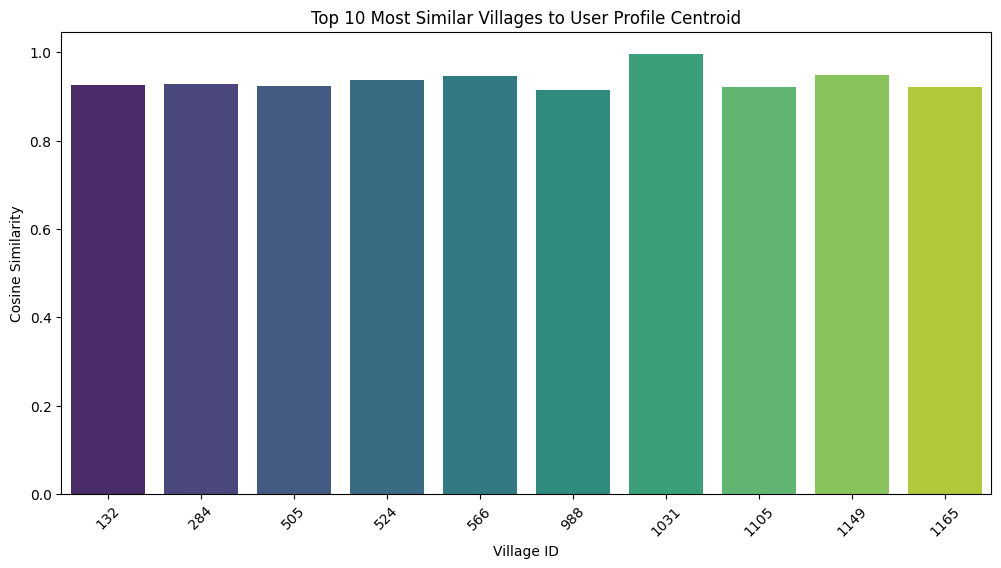

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 similar villages and their scores
top_villages = ranked_villages[:10]
village_ids = [v for v, _ in top_villages]
similarity_scores = [s for _, s in top_villages]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
plt.xlabel("Village ID")
plt.ylabel("Cosine Similarity")
plt.title("Top 10 Most Similar Villages to User Profile Centroid")
plt.xticks(rotation=45)
plt.show()